# Test Problem : Solving Damped Harmonic Oscillator DE over varying Damping Ratio

    Using PyTorch, solve the damped harmonic oscillator [5] using a PINN. Choose fixed initial conditions:
    x(0) = x₀,
     dx/dz(0) = v₀, with x₀ = 0.7 and v₀ = 1.2.
    
    Condition the PINN on damping ratios in the range ξ = 0.1 to 0.4.
    Solve on the domain z ∈ [0, 20]:
    d²x/dz² + 2ξ·dx/dz + x = 0


## Solution Overview:

- The Damped Harmonic Oscillator DE for a varying damping constant in range [0.1, 0.4] is solved using a simple PINN with the aide of Inital Condition Loss and PDE loss.
- A MSE (Mean Square Error) loss threshold of 6e-5 is used to converge the model and results are plotted.

### Importing Libraries

In [35]:
# Importing the necessary libraries:

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display, HTML
import os
import torch
import torch.nn as nn
import torch.optim as optim

#### Functions to avoid errors in Pytorch workflow (may be useful in large scripts):

In [36]:
# Check for device (CPU/CUDA):
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


# Ensures the tensor is on cpu before converting to a Numpy array for plotting purpose
def ensure_cpu(tensor_input):

    if isinstance(tensor_input, torch.Tensor):
        if tensor_input.is_cuda:
            return tensor_input.detach().cpu()
        else:
            return tensor_input
    elif isinstance(tensor_input, (list, tuple)):
        return type(tensor_input)(ensure_cpu(item) for item in tensor_input)
    elif isinstance(tensor_input, dict):
        return {key: ensure_cpu(value) for key, value in tensor_input.items()}
    else:
        return tensor_input

# to convert numpy to tensor wherever needed:
def to_tensor(data):
    if isinstance(data, torch.Tensor):
        return data.float()
    elif isinstance(data, np.ndarray):
        return torch.from_numpy(data).float()
    else:
        return torch.tensor(data, dtype=torch.float32)  # to avoid float32 - float 64 mismatch


Using device: cuda


#### Defining Analytical solution for random damping ratio in range [0,4] for training and testing purpose:

In [37]:
"""
For generating Analytical solution for Damped Oscillator for given intial conditions and damping
"""
x0 = 0.7
v0 = 1.2
z = np.linspace(0, 20, 3200)  # Time domain points
d = np.random.uniform(0.1, 0.4) # randomly selecting a damping constant between 0.1 and 0.4
d = 0.1
print(f"Randomly Selected damping constant: {d}")

def damped_oscillator(z, d):
    omega_d = np.sqrt(1 - d**2)  # Damped frequency
    C1 = x0
    C2 = (v0 + d * x0) / omega_d
    y = np.exp(-d * z) * (C1 * np.cos(omega_d * z) + C2 * np.sin(omega_d * z))
    return y

x = damped_oscillator(z, d)

Randomly Selected damping constant: 0.1


#### Model Architecture:

In [38]:
# defining the model architecture:

class Model(nn.Module):
    "Defines a connected network"
    
    def __init__(self, n_input, n_ouput, n_hidden, n_layers):
        super().__init__()
        activation = nn.Tanh
        self.input = nn.Sequential(*[
                        nn.Linear(n_input, n_hidden),
                        activation()])
        self.hidden = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(n_hidden, n_hidden),
                            activation()]) for _ in range(n_layers-1)])
        self.output = nn.Linear(n_hidden, n_ouput)
        
    def forward(self, x):
        x = self.input(x)
        x = self.hidden(x)
        x = self.output(x)
        return x

### Plotting function for Pure Physics PINN:

In [39]:
def plot_result1(z, x, x_pred, x_0, d):
    # converting GPU tensors to CPU for plotting:
    z = ensure_cpu(z)
    x = ensure_cpu(x)
    x_pred = ensure_cpu(x_pred)
    
    
    # plotting:
    plt.figure(figsize=(8,4))
    plt.plot(z, x, color="grey", linewidth=2, alpha=0.8, label="Analytical solution")
    plt.plot(z, x_pred, color="blue", linewidth=4, alpha=0.8, label="PINN prediction")
    plt.scatter(z[0],x_0, color = "yellow", alpha = 0.6)
    legend = plt.legend(loc=(1.01,0.34), frameon=False, fontsize="large")
    plt.setp(legend.get_texts(), color="k")
    plt.xlim(-0.05, 20.05)
    plt.ylim(-2, 2)
    plt.text(1.85,1.5,"Training step: %i ; damping constant = %.2f "%(i+1, d),fontsize="xx-large",color="k")
    plt.xlabel("Time (z)", fontsize="xx-large")
    plt.ylabel("Displacement (x)", fontsize="xx-large")

In [40]:
# preparing time variable for generating differentials:

z = to_tensor(z).to(device)
z = z.view(-1,1)
z = z.requires_grad_(True)


In [41]:
"""
Model  and Optimization:
"""
torch.manual_seed(123)
model = Model(1,1,32,3)
model = model.to(device)

# Losses for prinitng :
total_loss = []
PDE_Loss = []
IC_Loss =[]

"  ICs:  "
x_0 = 0.7
v_0 = 1.2


optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
files = [] # for saving solution

max_epochs = 30000 # saftey limit for model convergence


Iteration 1 - Loss: 0.310678, IC Loss: 2.450637, PDE Loss: 0.065614
Iteration 301 - Loss: 0.010177, IC Loss: 0.007325, PDE Loss: 0.009444
Iteration 601 - Loss: 0.007653, IC Loss: 0.003430, PDE Loss: 0.007310
Iteration 901 - Loss: 0.004766, IC Loss: 0.001543, PDE Loss: 0.004611
Iteration 1201 - Loss: 0.003382, IC Loss: 0.000698, PDE Loss: 0.003312
Iteration 1501 - Loss: 0.002168, IC Loss: 0.000400, PDE Loss: 0.002128
Iteration 1801 - Loss: 0.001962, IC Loss: 0.000222, PDE Loss: 0.001940
Iteration 2101 - Loss: 0.001848, IC Loss: 0.000195, PDE Loss: 0.001828
Iteration 2401 - Loss: 0.001576, IC Loss: 0.000158, PDE Loss: 0.001560
Iteration 2701 - Loss: 0.000824, IC Loss: 0.000105, PDE Loss: 0.000813
Iteration 3001 - Loss: 0.000383, IC Loss: 0.000026, PDE Loss: 0.000381
Iteration 3301 - Loss: 0.000291, IC Loss: 0.000011, PDE Loss: 0.000290
Iteration 3601 - Loss: 0.000237, IC Loss: 0.000009, PDE Loss: 0.000237
Iteration 3901 - Loss: 0.000141, IC Loss: 0.000007, PDE Loss: 0.000140
Iteration 42

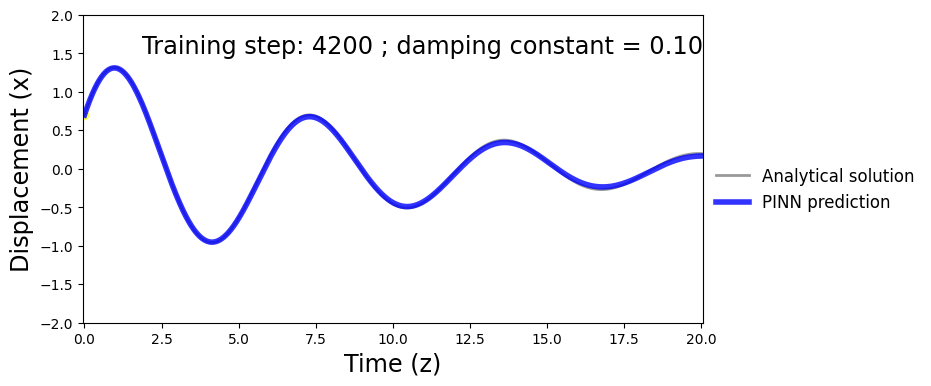

In [42]:
"TRAINING"

i = 0 # iteration counter
while i< max_epochs:
    optimizer.zero_grad() # to prevent accumulation of gradients
    x_pred = model(z) # predictions
   
    
    " Defining PDE loss:"
    # PDE predictions:
    dx = torch.autograd.grad(x_pred, z, torch.ones_like(x_pred), create_graph=True)[0] # computes dy/dx
    dx2 = torch.autograd.grad(dx,  z, torch.ones_like(dx),  create_graph=True)[0] # computes d^2y/dx^2
    p_residual = dx2 + 2*d*dx + x_pred # computes residual of harmonic oscillator equation
    
    # PDE loss:
    PDE_loss = torch.mean(p_residual**2) # L2 norm of PDE loss
    
    
    "Defining IC loss:"
# IC predictions:
    x0_pred = model(z[0]) # initial displacement
    # dx_0 = torch.autograd.grad(x0_pred, z[0], torch.ones_like(x0_pred), create_graph=True)[0] # initial velocity ([0] is used as derivative with respect to only 1 tensor)
    dx_0 = dx[0]
    # IC loss:
    IC_loss = (x0_pred - x_0)**2 + (dx_0 - v_0)**2 # L2 norm of IC loss
    
    
    # Backpropagating joint loss:
    loss = 0.1 * IC_loss + 1 * PDE_loss # total loss
    total_loss.append(loss.item())
    PDE_Loss.append(PDE_loss.item())
    IC_Loss.append(IC_loss.item())
    
    loss.backward()
    optimizer.step()
    
    if i % 300 == 0:
        print(f"Iteration {i+1} - Loss: {loss.item():.6f}, IC Loss: {IC_loss.item():.6f}, PDE Loss: {PDE_loss.item():.6f}")
    
    
    
    
    # Stopping Criteria:
    threshold = 6e-5 # loss threshold
    if loss.item() < threshold:
        print(f"Stopping early at iteration {i+1}: Loss reached {loss.item():.6f}")
        break
    
    if (i+1) % 600 == 0:
        x_pred = model(z).detach()
        plot_result1(z, x, x_pred, x_0, d)
        
        file = f"C:\\Users\\mehul\\MyLab\\PINNDE\\plot3\\phy_pinn_{i+1:08d}.png"
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
        plt.close()
       

    i += 1



# Showing end results:
if files:  # Ensure there are saved files before trying to display
    last_image = files[-1]  # Get the last saved image path
    from IPython.display import display
    from PIL import Image

    display(Image.open(last_image))



In [43]:
# for saving GIFs of the solution:
def save_gif_PIL(outfile, files, fps=10, loop=0):
    "Helper function for saving GIFs"
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)
    
    
def display_gif(gif_path):
    """Display the GIF with autoplay"""
    return HTML(f'<img src="{gif_path}" alt="PINN Training Animation" style="width:100%">')

# Save and Show animation
save_gif_PIL("phy_pinn.gif", files, fps=10, loop=0)
display(display_gif("phy_pinn.gif"))


### Convergence plot:

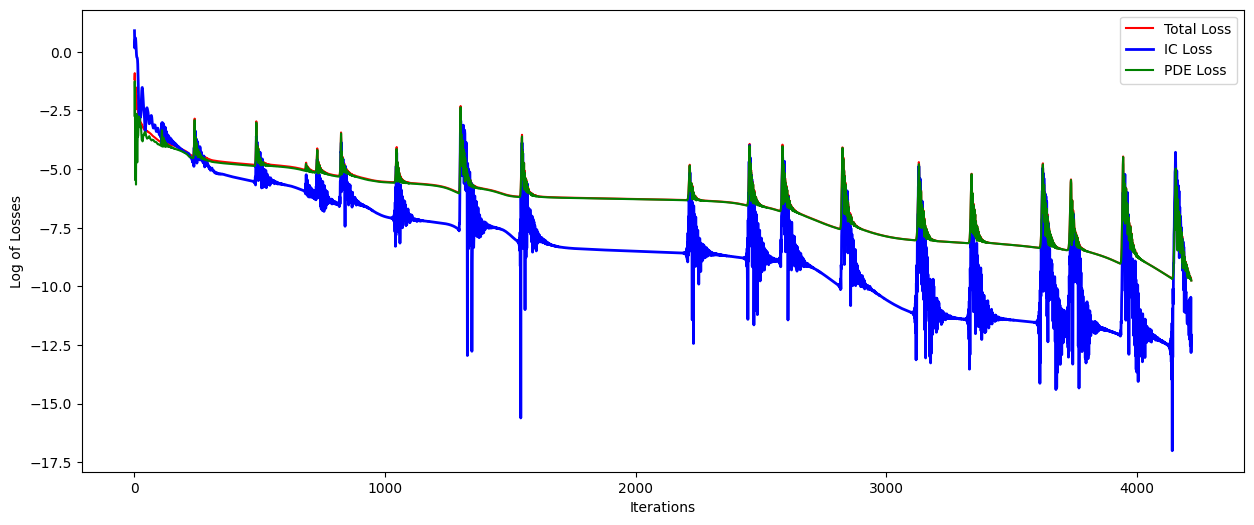

In [44]:
#  Plot Losses
iterations = np.arange(1, len(total_loss) + 1)
plt.figure(figsize=(15,6))
plt.plot(iterations, np.log(total_loss), color="red", label="Total Loss")
plt.plot(iterations, np.log(IC_Loss), color="blue", linewidth=2, label="IC Loss")
plt.plot(iterations, np.log(PDE_Loss), color="green", label="PDE Loss")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Log of Losses")
plt.show()
